In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold,  StratifiedKFold
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import files
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# **Tải thư viện hỗ trợ xgBoost và thêm xgboost vào**

In [2]:
!pip install scikit-learn==1.3.2
!pip install xgboost==1.7.6

In [3]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# **Tải dữ liệu và thống kê dữ liệu**

In [4]:
#https://www.kaggle.com/datasets/assimediakhate/global-disaster-2018-2024
uploaded = files.upload()   # chọn file CSV từ máy

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print(df.shape)
df.head()

Saving global_disaster_response_2018_2024.csv to global_disaster_response_2018_2024.csv
(50000, 12)


,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
0,2021-01-31,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557
1,2018-12-23,Brazil,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194
2,2020-08-10,India,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978
3,2022-09-15,Indonesia,Extreme Heat,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350
4,2022-09-28,United States,Wildfire,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137


# **Tiền xử lý dữ liệu**

**KHÁM PHÁ DỮ LIỆU**

In [5]:
df.describe()

,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
count,50000.000000,50000.000000,5.000000e+04,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.015769,100.591140,5.068593e+06,12.183027,2.500003e+05,87.574025,49.682560,0.231205,0.089889
std,1.942843,65.052064,3.268541e+06,9.259081,1.432275e+05,10.188961,20.098944,34.759662,98.380208
min,1.000000,0.000000,5.273900e+02,1.000000,1.660000e+01,29.750000,2.000000,-59.994000,-169.998000
25%,3.660000,51.000000,2.585513e+06,6.270000,1.429663e+05,83.060000,36.000000,-29.848250,-85.551750
50%,4.990000,91.000000,4.548351e+06,10.510000,2.305365e+05,89.180000,49.000000,0.267500,0.390500
75%,6.340000,138.000000,6.950615e+06,15.450000,3.352259e+05,94.700000,63.000000,30.488250,85.665000
max,10.000000,524.000000,2.445624e+07,63.100000,1.126465e+06,100.000000,112.000000,59.997000,169.999000


In [6]:
# kiểm tra kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       50000 non-null  object 
 1   country                    50000 non-null  object 
 2   disaster_type              50000 non-null  object 
 3   severity_index             50000 non-null  float64
 4   casualties                 50000 non-null  int64  
 5   economic_loss_usd          50000 non-null  float64
 6   response_time_hours        50000 non-null  float64
 7   aid_amount_usd             50000 non-null  float64
 8   response_efficiency_score  50000 non-null  float64
 9   recovery_days              50000 non-null  int64  
 10  latitude                   50000 non-null  float64
 11  longitude                  50000 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 4.6+ MB


## **Miền giá trị của các featues**

In [7]:
# In ra miền giá trị của từng features
features = {}

for col in df.columns:
    # lấy tối đa 20 giá trị unique để bảng không quá dài
    uniques = df[col].unique()
    if len(uniques) > 20:
        uniques = uniques[:20]

    features[col] = uniques

pd.DataFrame(dict([(k, pd.Series(v)) for k, v in features.items()]))


,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
0,2021-01-31,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557
1,2018-12-23,India,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194
2,2020-08-10,Indonesia,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978
3,2022-09-15,United States,Wildfire,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350
4,2022-09-28,France,Flood,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137
5,2019-01-15,Germany,Storm Surge,2.56,56,51588.22,12.12,137988.29,91.57,26,-14.409,-47.947
6,2020-12-19,Greece,Drought,4.77,81,1243386.99,6.47,194502.18,98.82,49,36.855,78.109
7,2022-03-31,Spain,Tornado,1.47,34,1190129.51,29.18,91727.22,75.97,19,-50.544,-70.319
8,2024-06-22,Mexico,Landslide,3.32,73,3871721.46,19.33,134246.08,79.74,27,-36.925,-146.351
9,2018-11-23,South Africa,Volcanic Eruption,2.61,202,4375843.52,18.05,182715.32,83.76,57,42.638,124.604


In [8]:
print(df.columns.tolist())


['date', 'country', 'disaster_type', 'severity_index', 'casualties', 'economic_loss_usd', 'response_time_hours', 'aid_amount_usd', 'response_efficiency_score', 'recovery_days', 'latitude', 'longitude']


## **Kiểm tra Imbalance Data**


 KIỂM TRA IMBALANCE — disaster_type 

--- Phân bố giá trị của disaster_type ---


,count
disaster_type,
Landslide,5130
Earthquake,5068
Flood,5039
Hurricane,5002
Extreme Heat,5001
Storm Surge,4988
Volcanic Eruption,4983
Wildfire,4954
Tornado,4939


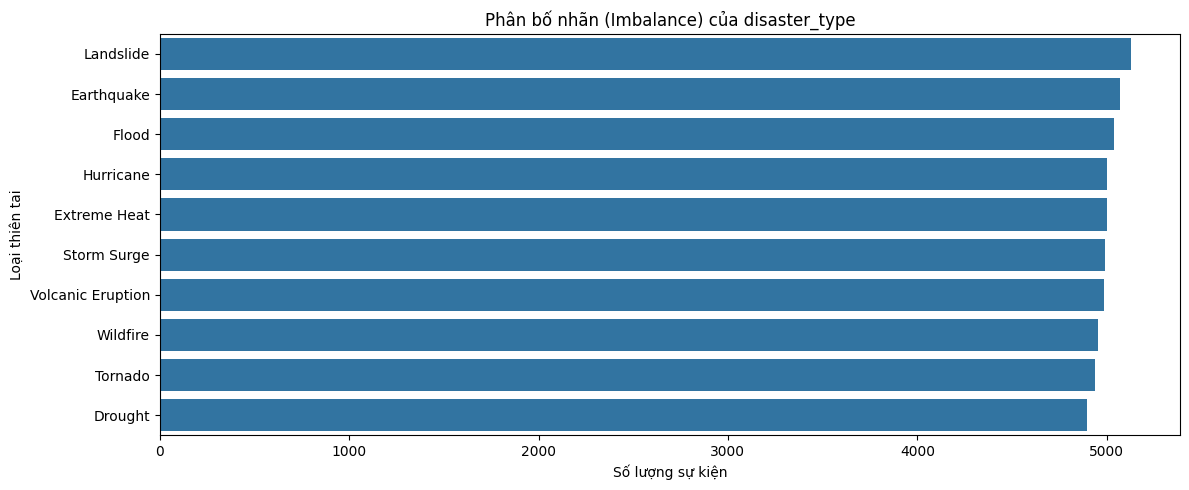

In [9]:
print("\n KIỂM TRA IMBALANCE — disaster_type ")

# Kiểm tra cột có tồn tại không
if "disaster_type" not in df.columns:
    print("Dataset không có cột 'disaster_type'. Kiểm tra lại tên cột.")
else:
    # Đếm tần suất
    df['disaster_type'] = df['disaster_type'].fillna('Unknown') #xử lý NaN
    vc = df['disaster_type'].value_counts()

    print("\n--- Phân bố giá trị của disaster_type ---")
    display(vc)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 5))
    sns.barplot(x=vc.values, y=vc.index)
    plt.title("Phân bố nhãn (Imbalance) của disaster_type")
    plt.xlabel("Số lượng sự kiện")
    plt.ylabel("Loại thiên tai")
    plt.tight_layout()
    plt.show()


# **Thống kê mật độ**


THỐNG KÊ MẬT ĐỘ (DENSITY PLOT) 
Các cột số: ['severity_index', 'casualties', 'economic_loss_usd', 'response_time_hours', 'aid_amount_usd', 'response_efficiency_score', 'recovery_days', 'latitude', 'longitude']


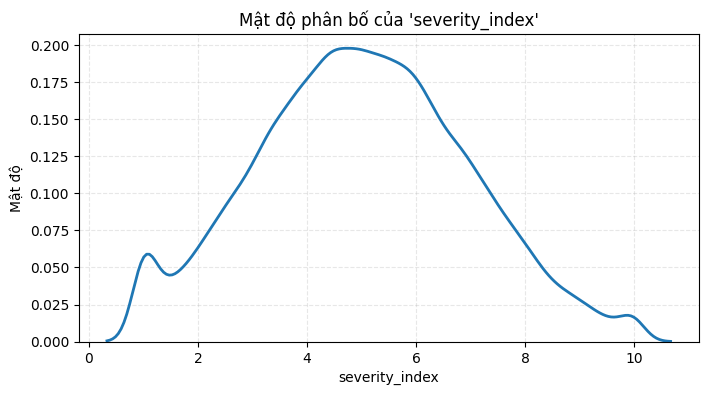

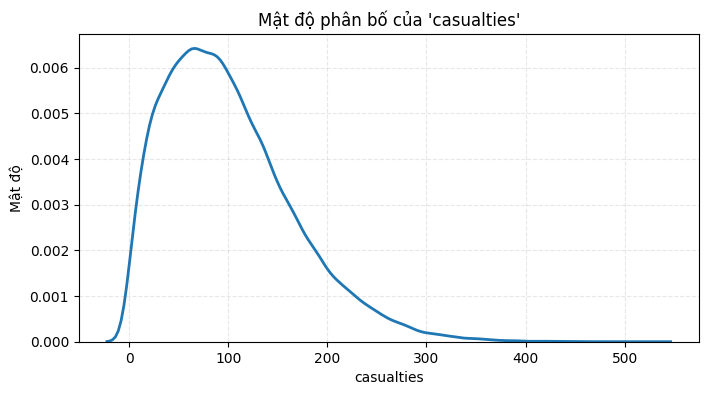

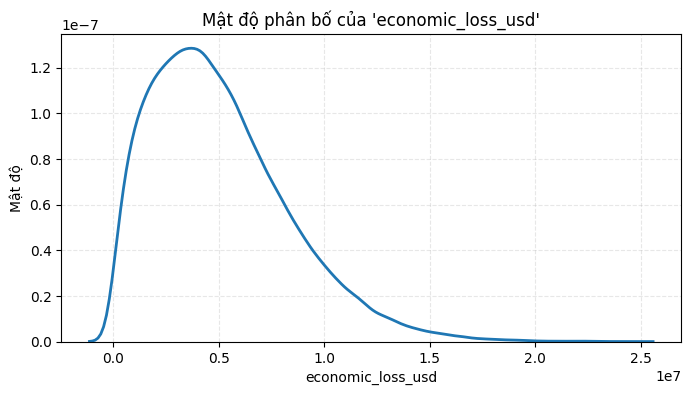

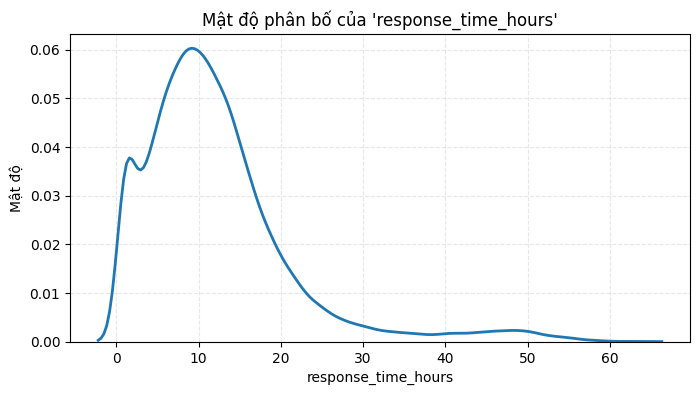

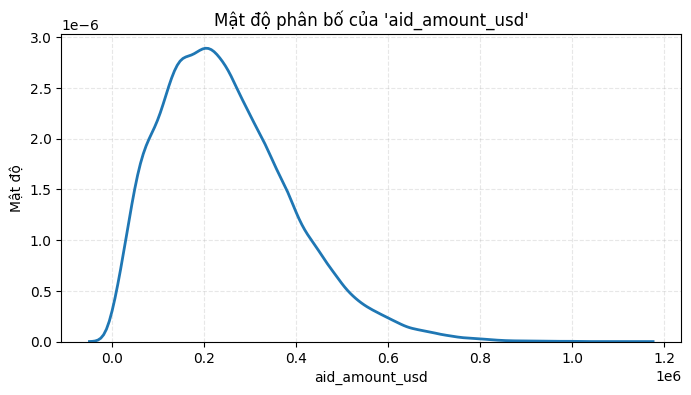

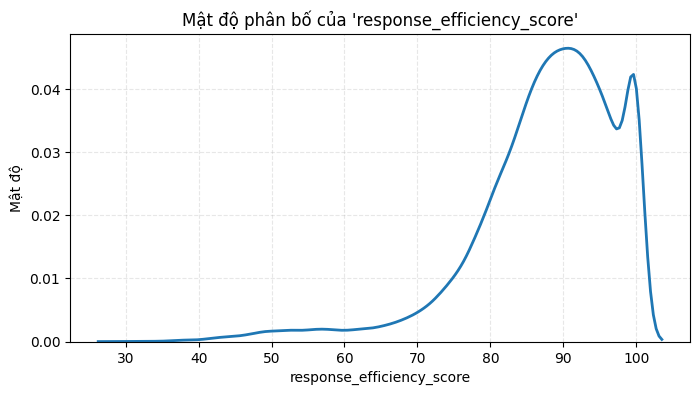

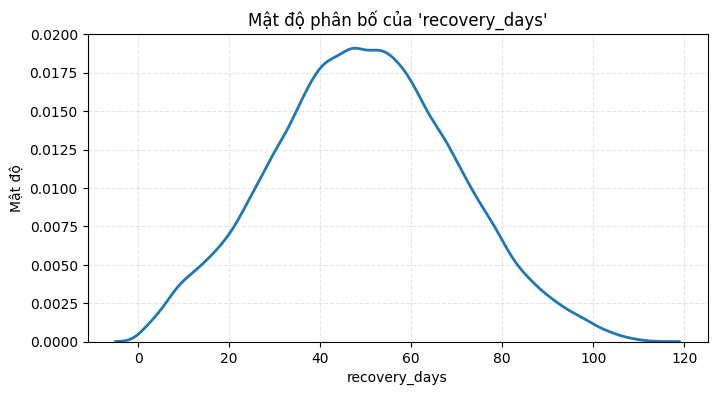

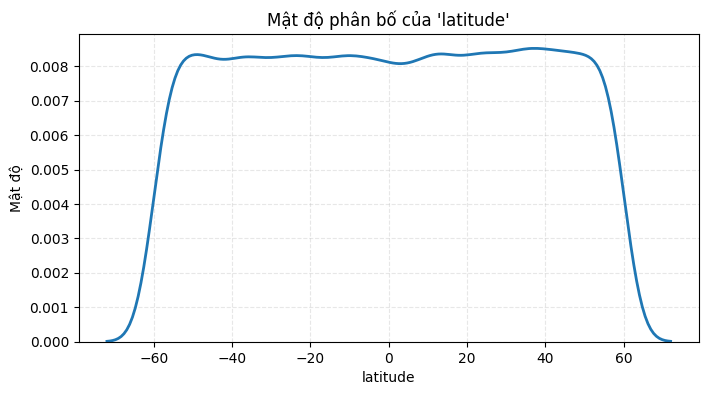

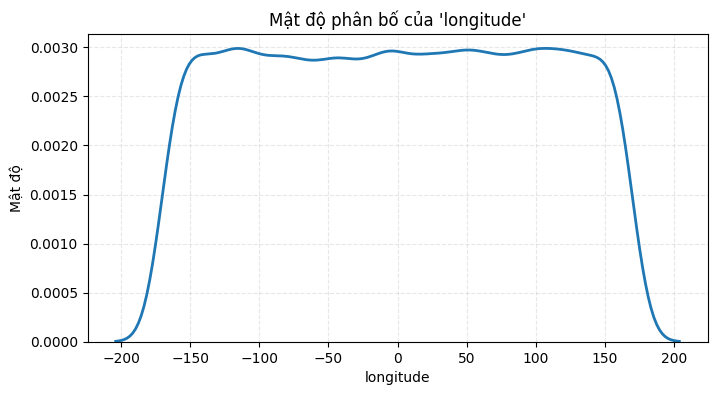

In [10]:
# THỐNG KÊ MẬT ĐỘ (mô tả phân bố giá trị của biến số theo dạng đường cong xác suất.)
print("\nTHỐNG KÊ MẬT ĐỘ (DENSITY PLOT) ")

# Lấy các cột kiểu số
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if len(numeric_cols) == 0:
    print("Dataset không có cột số để vẽ mật độ.")
else:
    print("Các cột số:", numeric_cols)

    # Vẽ mật độ từng cột số
    for col in numeric_cols:
        try:
            plt.figure(figsize=(8,4))
            sns.kdeplot(df[col].dropna(), linewidth=2)
            plt.title(f"Mật độ phân bố của '{col}'")
            plt.xlabel(col)
            plt.ylabel("Mật độ")
            plt.grid(True, linestyle="--", alpha=0.3)
            plt.show()
        except Exception as e:
            print(f"Không thể vẽ mật độ cho cột {col}: {e}")


## **TẦN SỐ THIÊN TAI THEO QUỐC GIA**


TẦN SỐ XUẤT HIỆN THIÊN TAI Ở CÁC QUỐC GIA 
Cột quốc gia tìm được: country

--- Top 20 quốc gia có thiên tai nhiều nhất ---


,count
country,
Brazil,2591
Australia,2563
Turkey,2554
Bangladesh,2553
Spain,2543
China,2539
Chile,2529
Nigeria,2528
Germany,2526


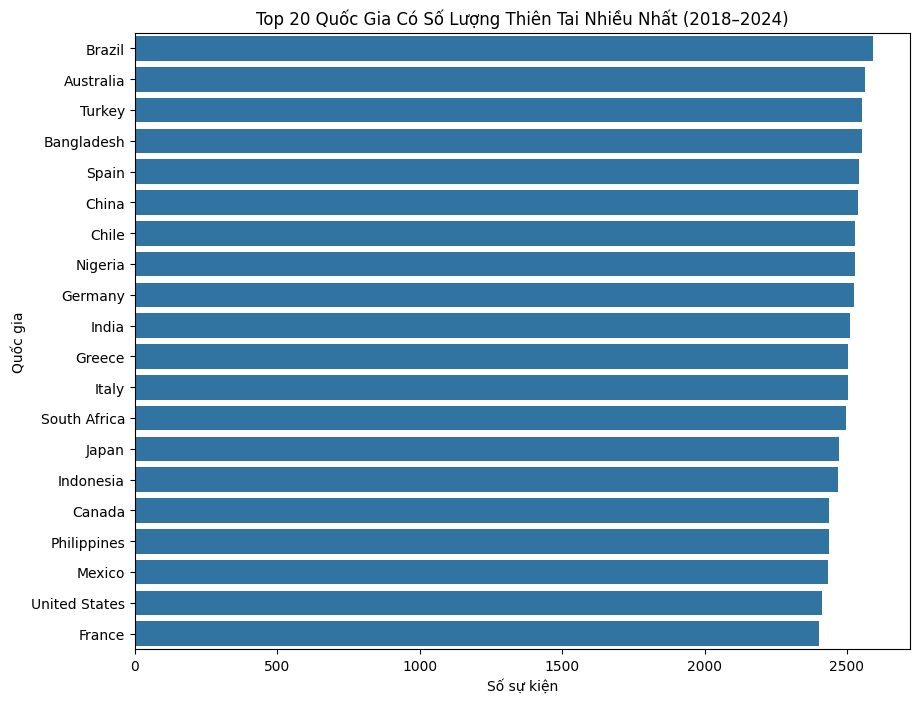

In [11]:

print("\nTẦN SỐ XUẤT HIỆN THIÊN TAI Ở CÁC QUỐC GIA ")

country_cols = [c for c in df.columns if "country" in c.lower()]

if len(country_cols) == 0:
    print("Dataset không có cột country để thống kê.")
else:
    col_country = country_cols[0]
    print("Cột quốc gia tìm được:", col_country)

# Đếm tần số
country_count = df[col_country].value_counts().dropna()

print("\n--- Top 20 quốc gia có thiên tai nhiều nhất ---")
display(country_count.head(20))

# Vẽ biểu đồ Top 20
plt.figure(figsize=(10,8))
sns.barplot(
    x=country_count.head(20).values,
    y=country_count.head(20).index
)
plt.title("Top 20 Quốc Gia Có Số Lượng Thiên Tai Nhiều Nhất (2018–2024)")
plt.xlabel("Số sự kiện")
plt.ylabel("Quốc gia")
plt.show()

## **Mã hóa biến phân loại và chia dữ liệu**

**Chuyển cột date sang datetime**

In [12]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Tạo feature từ date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

if df['year'].isnull().any():
    df['year'] = df['year'].fillna(df['year'].median())
if df['month'].isnull().any():
    df['month'] = df['month'].fillna(df['month'].median())

**Encoding**

In [13]:
df_encoded = df.copy()

# Encode disaster_type (TARGET)
le_disaster = LabelEncoder()
df_encoded['disaster_type_encoded'] = le_disaster.fit_transform(
    df_encoded['disaster_type']
)

# Encode country
le_country = LabelEncoder()
df_encoded['country_encoded'] = le_country.fit_transform(
    df_encoded['country']
)

print(df_encoded.head())


        date        country disaster_type  severity_index  casualties  \
0 2021-01-31         Brazil    Earthquake            5.99         111   
1 2018-12-23         Brazil  Extreme Heat            6.53         100   
2 2020-08-10          India     Hurricane            1.55          22   
3 2022-09-15      Indonesia  Extreme Heat            4.55          94   
4 2022-09-28  United States      Wildfire            3.80          64   

   economic_loss_usd  response_time_hours  aid_amount_usd  \
0         7934365.71                15.62       271603.79   
1         8307648.99                 5.03       265873.81   
2          765136.99                32.54        49356.49   
3         1308251.31                 7.83       237512.88   
4         2655864.36                21.90       188910.69   

   response_efficiency_score  recovery_days  latitude  longitude  year  month  \
0                      83.21             67   -30.613   -122.557  2021      1   
1                      96.18    

In [14]:
X = df_encoded.drop(
    ['date', 'disaster_type', 'disaster_type_encoded', 'country'],
    axis=1
)
y = df_encoded['disaster_type_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)

(40000, 12) (10000, 12)


## **Xóa cột features bị trùng**

In [15]:
#  PHÁT HIỆN CỘT TRÙNG NHAU HOÀN TOÀN
duplicate_columns = []
cols = df.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if df[cols[i]].equals(df[cols[j]]):
            duplicate_columns.append(cols[j])

In [16]:
# Xóa cột trùng
if len(duplicate_columns) > 0:
    print("Các cột bị trùng hoàn toàn:", duplicate_columns)
    df = df.drop(columns=duplicate_columns)
else:
    print("Không tìm thấy cột trùng lặp hoàn toàn.")

Không tìm thấy cột trùng lặp hoàn toàn.


In [17]:
print(len(df.columns))

14


# Missing Vaue

In [18]:
# Kiểm tra số lượng giá trị missing từng cột
missing_values = df.isnull().sum()

# In ra tất cả các cột có giá trị missing > 0
missing_values_nonzero = missing_values[missing_values > 0]

if missing_values_nonzero.empty:
    print("Không có giá trị missing trong dataset.")
else:
    print("Các cột có giá trị missing và số lượng missing:")
    print(missing_values_nonzero)

Không có giá trị missing trong dataset.


### **Kiểm tra các cột null**

In [19]:
# kiểm tra null
print(df.isnull().sum().to_string())

date                         0
country                      0
disaster_type                0
severity_index               0
casualties                   0
economic_loss_usd            0
response_time_hours          0
aid_amount_usd               0
response_efficiency_score    0
recovery_days                0
latitude                     0
longitude                    0
year                         0
month                        0


## **Biểu đồ biểu diễn mối tương quan của các biến**


BIỂU ĐỒ TƯƠNG QUAN GIỮA CÁC BIẾN SỐ

--- Ma trận tương quan ---


,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
severity_index,1.000000,0.601808,0.601611,-0.676265,0.671538,0.600417,0.968534,0.004979,0.005499
casualties,0.601808,1.000000,0.373459,-0.405880,0.401697,0.359054,0.581541,0.003702,-0.003863
economic_loss_usd,0.601611,0.373459,1.000000,-0.406406,0.400094,0.360331,0.581612,0.005411,-0.000795
response_time_hours,-0.676265,-0.405880,-0.406406,1.000000,-0.455038,-0.886584,-0.654478,-0.005173,-0.003151
aid_amount_usd,0.671538,0.401697,0.400094,-0.455038,1.000000,0.404442,0.649868,0.001030,0.006108
response_efficiency_score,0.600417,0.359054,0.360331,-0.886584,0.404442,1.000000,0.579997,0.004077,0.003919
recovery_days,0.968534,0.581541,0.581612,-0.654478,0.649868,0.579997,1.000000,0.003866,0.004028
latitude,0.004979,0.003702,0.005411,-0.005173,0.001030,0.004077,0.003866,1.000000,0.004436
longitude,0.005499,-0.003863,-0.000795,-0.003151,0.006108,0.003919,0.004028,0.004436,1.000000


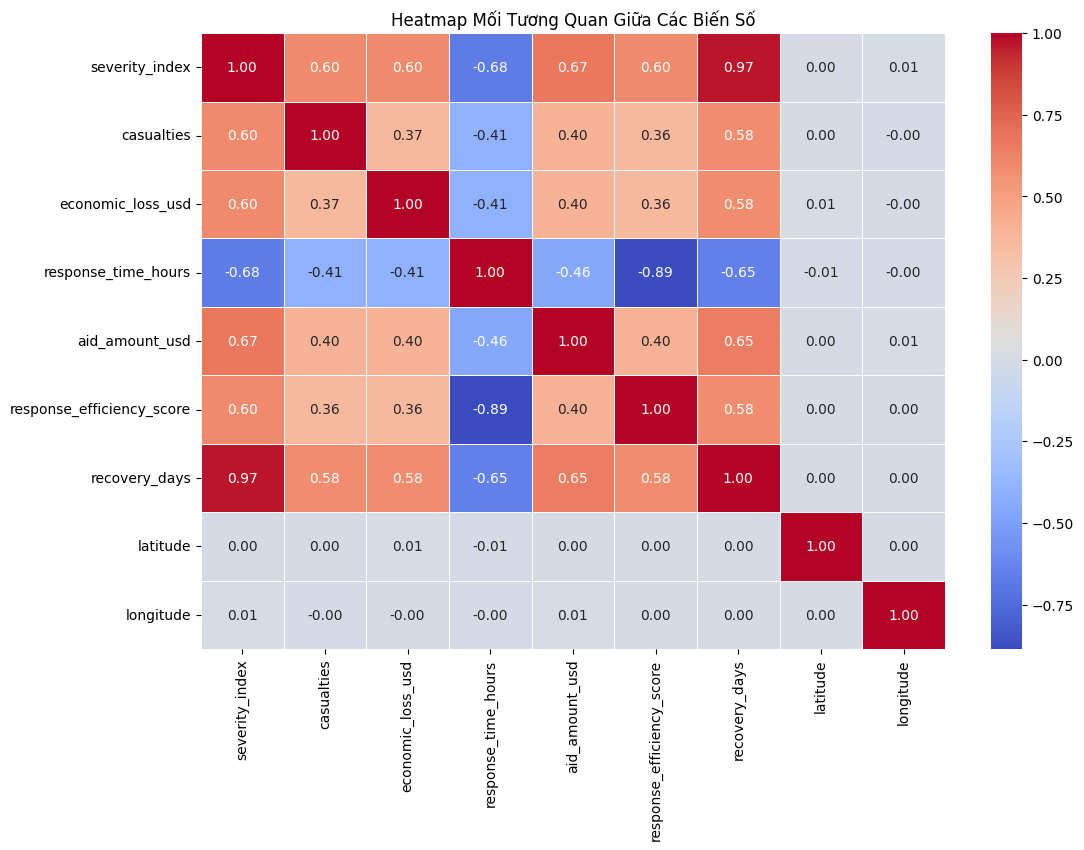

In [20]:
print("\nBIỂU ĐỒ TƯƠNG QUAN GIỮA CÁC BIẾN SỐ")

# Lấy các cột số
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

if len(numeric_cols) < 2:
    print("Không đủ cột số để vẽ heatmap tương quan.")
else:
    # Tính ma trận tương quan
    corr_matrix = df[numeric_cols].corr()

    print("\n--- Ma trận tương quan ---")
    display(corr_matrix)

    # Vẽ heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,         # hiển thị giá trị
        cmap="coolwarm",    # bảng màu trực quan
        linewidths=0.5,
        fmt=".2f"
    )
    plt.title("Heatmap Mối Tương Quan Giữa Các Biến Số")
    plt.show()


**Xử lý categorical**

In [21]:
categorical_cols = ['disaster_type', 'country']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].fillna('Unknown')
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

**Log-transform các biến lệnh**

In [22]:
skew_cols = ['economic_loss_usd', 'aid_amount_usd', 'casualties']
for col in skew_cols:
    # tránh log(0)
    df[col] = df[col].apply(lambda x: np.log1p(x) if pd.notnull(x) else 0)

 **Chọn X/y**

In [26]:
target = 'disaster_type'

features = [
    'country',
    'year', 'month',
    'casualties',
    'economic_loss_usd',
    'response_time_hours',
    'aid_amount_usd',
    'response_efficiency_score',
    'recovery_days',
    'latitude', 'longitude',
    'severity_index'
]

X = df[features]
y = df[target]


**Scale numeric features**

In [27]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('disaster_type')  # loại bỏ target nếu numeric
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

**Chọn X và Y:**

In [28]:
target = 'disaster_type'
features = [c for c in df.columns if c != target and c != 'date']

X = df[features]
y = df[target]

**Train/test split**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Dataset sẵn sàng cho modeling:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))

Dataset sẵn sàng cho modeling:
X_train: (40000, 12) X_test: (10000, 12)
y_train distribution:
 disaster_type
5    0.102600
1    0.101350
3    0.100775
4    0.100050
2    0.100025
6    0.099775
8    0.099650
9    0.099075
7    0.098775
0    0.097925
Name: proportion, dtype: float64


**Tóm tắt sau khi chuẩn hóa**

In [30]:
print("\n=== TÓM TẮT SAU KHI CHUẨN HÓA ===")
print("Số lượng cột:", X.shape[1])
print("Số dòng dữ liệu:", X.shape[0])
print("Các cột:", X.columns.tolist())


=== TÓM TẮT SAU KHI CHUẨN HÓA ===
Số lượng cột: 12
Số dòng dữ liệu: 50000
Các cột: ['country', 'severity_index', 'casualties', 'economic_loss_usd', 'response_time_hours', 'aid_amount_usd', 'response_efficiency_score', 'recovery_days', 'latitude', 'longitude', 'year', 'month']


# **Tóm tắt sau khi tiền xử lý**


===== TÓM TẮT SAU KHI TIỀN XỬ LÝ =====
- Số lượng cột còn lại sau khi xoá trùng lặp: 12
- Không có giá trị missing trong dataset
- Tổng số dòng dữ liệu: 50000
- Số cột số (numeric): 9
- Số cột phân loại (categorical): 3
- Tổng số ô bị thiếu (NaN): 0
- Tỷ lệ thiếu dữ liệu: 0.0%

# **Biểu đồ bảng cho các thuộc tính**

In [31]:
# Dữ liệu thuộc tính và mô tả:
descriptions = {
    "date": "ngày tháng năm xảy ra thiên tai",
    "country": "Quốc gia bị ảnh hưởng",
    "disaster_type": "Loại thiên tai",
    "casualties": "Thương vong",
    "economic_loss_usd": "Tổn thất kinh tế",
    "response_time_hours": "Thời gian phản hồi",
    "aid_amount_usd": "Số tiền viện trợ",
    "response_efficiency_score": "Hiệu quả phản hồi",
    "recovery_days": "Ngày hồi phục",
    "latitude": "Vĩ độ",
    "longitude": "Kinh độ",
    "severity_level": "Mức độ nghiêm trọng",
}

# Tạo column_info từ descriptions
column_info = [{
    "Thuộc tính": k,
    "Mô Tả": v
} for k, v in descriptions.items()]

# Tạo DataFrame
visualize = pd.DataFrame(column_info, columns=["Thuộc tính", "Mô Tả"])
# hiển thị bản
visualize

,Thuộc tính,Mô Tả
0,date,ngày tháng năm xảy ra thiên tai
1,country,Quốc gia bị ảnh hưởng
2,disaster_type,Loại thiên tai
3,casualties,Thương vong
4,economic_loss_usd,Tổn thất kinh tế
5,response_time_hours,Thời gian phản hồi
6,aid_amount_usd,Số tiền viện trợ
7,response_efficiency_score,Hiệu quả phản hồi
8,recovery_days,Ngày hồi phục
9,latitude,Vĩ độ


# **Lựa chọn mô hình**

## Chọn các mô hình như sau:


*   XGBoots
*   Random Forest
*   Logistic Regression


# **Chọn Random Forest làm model base**

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Khởi tạo mô hình
# ===============================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced",  # xử lý imbalance
    n_jobs=-1
)

**Train**

In [34]:
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

**Dự đoán**

In [35]:
y_pred = rf.predict(X_test)

**Đánh giá**

In [36]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.1003

 Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.11      0.10       979
           1       0.09      0.10      0.10      1014
           2       0.11      0.12      0.11      1000
           3       0.10      0.10      0.10      1008
           4       0.11      0.11      0.11      1000
           5       0.10      0.10      0.10      1026
           6       0.11      0.10      0.11       997
           7       0.10      0.10      0.10       988
           8       0.10      0.09      0.10       997
           9       0.08      0.07      0.08       991

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



**Confusion Matrix**

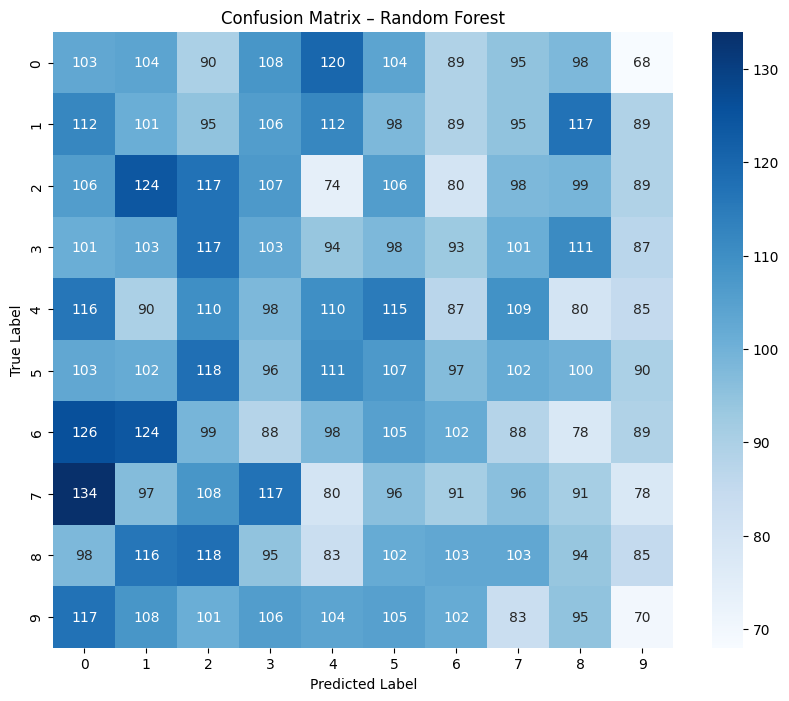

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


**Vẽ 1 nhánh cây trong Random Forest**

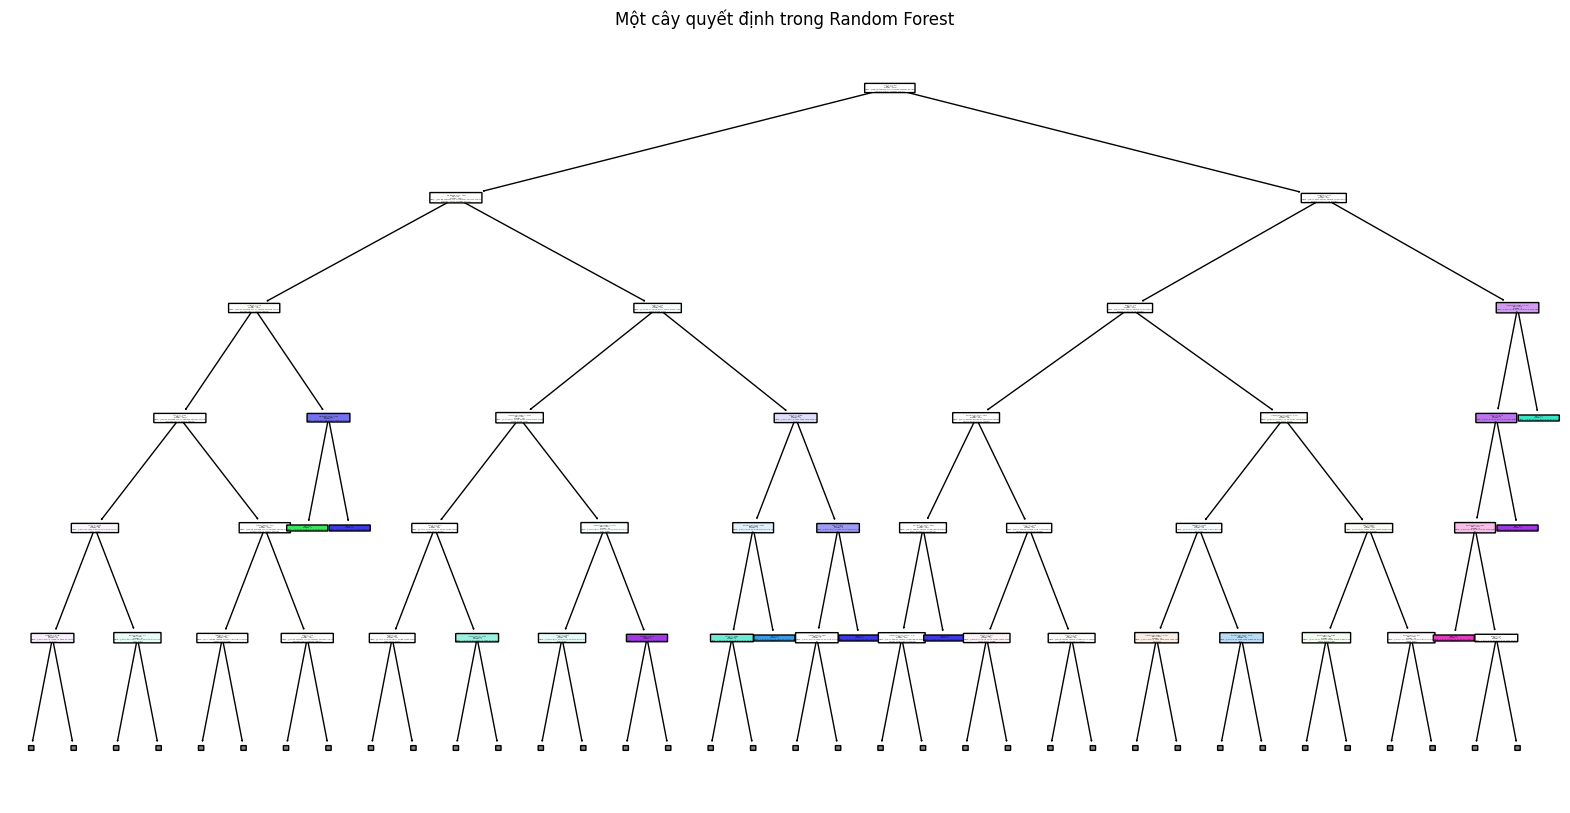

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Lấy 1 cây trong rừng
tree = rf.estimators_[0]   # cây đầu tiên

plt.figure(figsize=(20, 10))

plot_tree(
    tree,
    feature_names=X_train.columns,
    class_names=[str(c) for c in np.unique(y_train)],
    filled=True,
    rounded=True,
    max_depth=5
)

plt.title("Một cây quyết định trong Random Forest")
plt.show()


**Random Forest cho biết biến nào quan trọng**

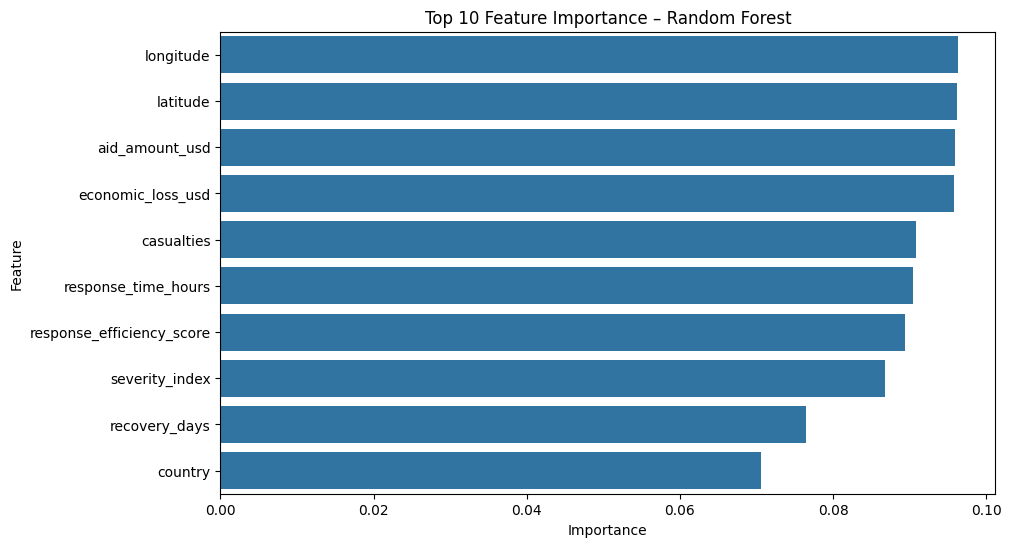

,Feature,Importance
9,longitude,0.096376
8,latitude,0.096155
5,aid_amount_usd,0.095917
3,economic_loss_usd,0.095765
2,casualties,0.090870
4,response_time_hours,0.090489
6,response_efficiency_score,0.089331
1,severity_index,0.086802
7,recovery_days,0.076414
0,country,0.070581


In [39]:
importances = rf.feature_importances_
feature_names = X_train.columns

fi = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Top 10
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=fi.head(10)
)
plt.title("Top 10 Feature Importance – Random Forest")
plt.show()

fi.head(10)


- Kết quả thực nghiệm cho thấy vị trí địa lý (vĩ độ và kinh độ) là yếu tố có ảnh hưởng lớn nhất.
Ngoài ra, các yếu tố phản ánh mức độ nghiêm trọng của thiên tai như tổn thất kinh tế, số thương vong và mức độ nghiêm trọng cũng đóng vai trò quan trọng trong việc phân loại loại thiên tai.

**Tune hyperparameter bằng GridSearchCV**

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_base = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

grid = GridSearchCV(
    rf_base,
    param_grid,
    cv=3,
    scoring="f1_weighted",
    verbose=2
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  31.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  18.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  30.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  33.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  31.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  17.5s
[CV] END max

**Train lại**

In [41]:
rf_best = grid.best_estimator_
y_pred_best = rf_best.predict(X_test)

print(classification_report(y_test, y_pred_best))


              precision    recall  f1-score   support

           0       0.10      0.11      0.10       979
           1       0.10      0.10      0.10      1014
           2       0.10      0.10      0.10      1000
           3       0.11      0.12      0.11      1008
           4       0.11      0.11      0.11      1000
           5       0.10      0.10      0.10      1026
           6       0.10      0.10      0.10       997
           7       0.10      0.10      0.10       988
           8       0.11      0.11      0.11       997
           9       0.08      0.08      0.08       991

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



- Mặc dù đã sử dụng GridSearchCV để tối ưu siêu tham số cho mô hình Random Forest, kết quả cho thấy độ chính xác và các chỉ số F1-score vẫn ở mức thấp.
Điều này cho thấy các đặc trưng hiện có chưa đủ mạnh để phân biệt rõ ràng giữa các loại thiên tai, đặc biệt trong bối cảnh bài toán phân loại đa lớp với nhiều lớp có đặc điểm tương đồng.

# **LOGISTIC REGRESSION**

**Tunning**

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Khởi tạo Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Định nghĩa lưới siêu tham số cho Logistic Regression, chỉ bao gồm các kết hợp hợp lệ
param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'penalty': ['l1', 'l2']},
    {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs'], 'penalty': ['l2']}
]

# Khởi tạo KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Định nghĩa các features (X) và target (y) từ DataFrame df đã được tiền xử lý
target = 'disaster_type'
features = [c for c in df.columns if c != target and c != 'date']

# Drop any remaining NaNs from the DataFrame before splitting into X and y
df_cleaned = df.dropna(subset=features + [target])

X = df_cleaned[features]
y = df_cleaned[target]

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Dataset sẵn sàng cho modeling:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))

# Khởi tạo Logistic Regression model (lấy từ cell SRGsQhcWjZog)
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Định nghĩa lưới siêu tham số cho Logistic Regression (lấy từ cell SRGsQhcWjZog)
param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'penalty': ['l1', 'l2']},
    {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs'], 'penalty': ['l2']}
]

# Khởi tạo KFold cross-validation (lấy từ cell SRGsQhcWjZog)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Khởi tạo GridSearchCV
grid_search_log_reg = GridSearchCV(
    estimator=log_reg_model,
    param_grid=param_grid,
    cv=kf,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Thực hiện tìm kiếm lưới trên tập huấn luyện
grid_search_log_reg.fit(X_train, y_train)
print("\nCác siêu tham số tốt nhất:")
print(grid_search_log_reg.best_params_)

print("\nĐộ chính xác tốt nhất của mô hình:")
print(grid_search_log_reg.best_score_)

# Lấy mô hình tốt nhất từ Grid Search và lưu vào best_log_reg_model
best_log_reg_model = grid_search_log_reg.best_estimator_

Dataset sẵn sàng cho modeling:
X_train: (40000, 12) X_test: (10000, 12)
y_train distribution:
 disaster_type
5    0.102600
1    0.101350
3    0.100775
4    0.100050
2    0.100025
6    0.099775
8    0.099650
9    0.099075
7    0.098775
0    0.097925
Name: proportion, dtype: float64
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Các siêu tham số tốt nhất:
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Độ chính xác tốt nhất của mô hình:
0.0936754972031715


**Lấy mô hình tối ưu Logistic Regression**

In [45]:
# Dự đoán trên tập kiểm tra bằng mô hình tốt nhất
y_pred_log_reg_best = best_log_reg_model.predict(X_test)
y_pred_proba_log_reg_best = best_log_reg_model.predict_proba(X_test)

### **Đánh giá mô hình Logistic Regression**

In [46]:
from sklearn.metrics import accuracy_score, classification_report

acc_log_reg = accuracy_score(y_test, y_pred_log_reg_best)
print(f"Accuracy (Logistic Regression): {acc_log_reg:.4f}")

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log_reg_best))

Accuracy (Logistic Regression): 0.0989

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.11      0.15      0.12       979
           1       0.10      0.10      0.10      1014
           2       0.09      0.08      0.08      1000
           3       0.10      0.14      0.12      1008
           4       0.11      0.03      0.05      1000
           5       0.10      0.09      0.09      1026
           6       0.10      0.13      0.11       997
           7       0.10      0.12      0.11       988
           8       0.09      0.13      0.11       997
           9       0.10      0.02      0.03       991

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.09     10000
weighted avg       0.10      0.10      0.09     10000



**Ma Trận Nhầm Lẫn**

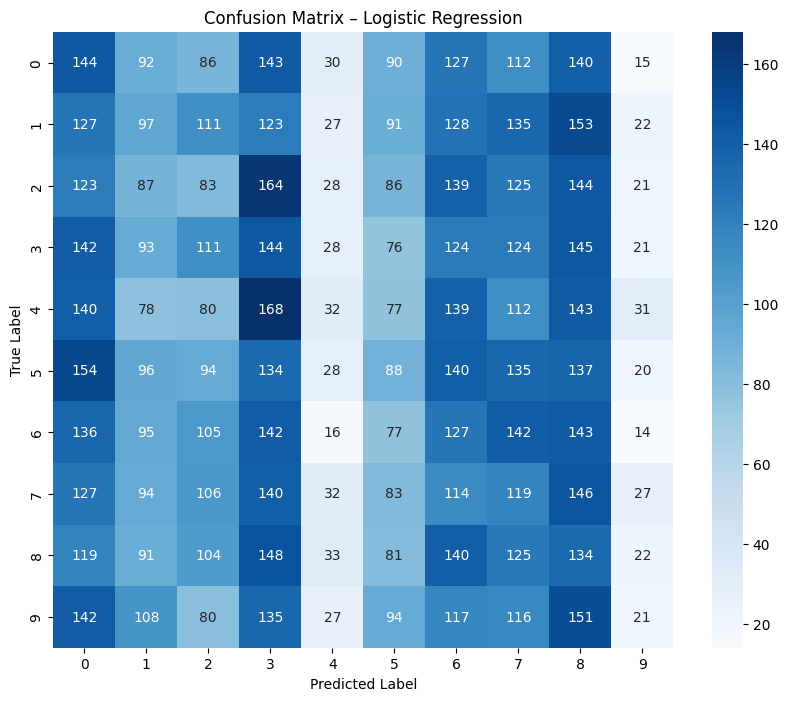

In [47]:
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg_best)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_log_reg,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **XGBoots**

**Tunning**

In [48]:
xgb_model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    xgb_model,
    param_grid,
    scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

print("Best CV score:", gs.best_score_)
print("Best params:", gs.best_params_)




Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV score: 0.09942869863644394
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


**Lấy mô hình tối ưu**

In [49]:
xg_model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    tree_method='hist',
    booster='gbtree',

    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,

    subsample=0.8,
    colsample_bytree=0.8,

    n_jobs=-1
)

# Huấn luyện mô hình
xg_model.fit(X_train, y_train)

sample_idx = 0
sample = X_test.iloc[sample_idx].values.reshape(1, -1)

pred = xg_model.predict(sample)

print("Predicted label:", pred[0])
print("Actual label:", y_test.iloc[sample_idx])

Predicted label: 0
Actual label: 2


In [50]:
xg_best_model = gs.best_estimator_
xg_pred = xg_best_model.predict(X_test)


**Ma Trận Nhầm lẫn**

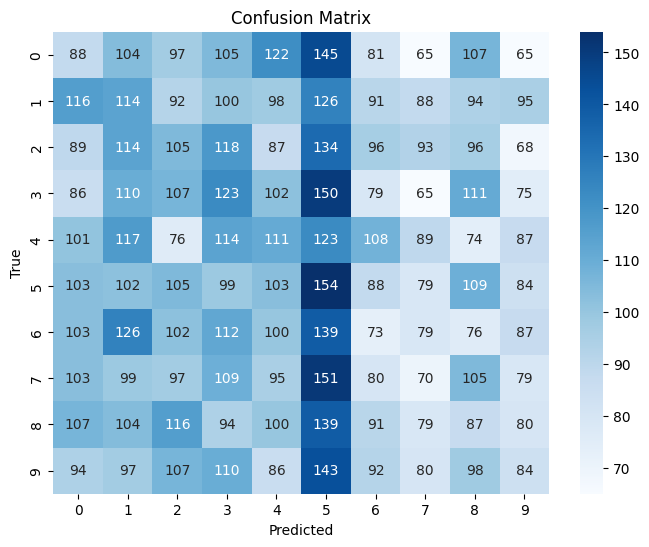

In [51]:
# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, xg_pred)
# Trực quan hóa ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xg_model.classes_, yticklabels=xg_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**Các thông số**

In [52]:
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       0.09      0.09      0.09       979
           1       0.10      0.11      0.11      1014
           2       0.10      0.10      0.10      1000
           3       0.11      0.12      0.12      1008
           4       0.11      0.11      0.11      1000
           5       0.11      0.15      0.13      1026
           6       0.08      0.07      0.08       997
           7       0.09      0.07      0.08       988
           8       0.09      0.09      0.09       997
           9       0.10      0.08      0.09       991

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



**Hàm làm mát log loss**

In [53]:
y_pred_prob = xg_model.predict_proba(X_test)
# Tính toán Log Loss
xg_loss = log_loss(y_test, y_pred_prob)
print("Log Loss:", xg_loss)

Log Loss: 2.3280193260400894


# **Phân Tích**

**Đặc trưng của các class**

In [54]:
from sklearn.tree import export_text,plot_tree
tree_rules = export_text(rf_best.estimators_[0], feature_names=X.columns.tolist())
print(tree_rules)

|--- latitude <= 0.96
|   |--- aid_amount_usd <= 1.62
|   |   |--- casualties <= 1.94
|   |   |   |--- latitude <= -1.72
|   |   |   |   |--- country <= -0.17
|   |   |   |   |   |--- casualties <= 0.25
|   |   |   |   |   |   |--- response_efficiency_score <= 0.08
|   |   |   |   |   |   |   |--- latitude <= -1.73
|   |   |   |   |   |   |   |   |--- class: 7.0
|   |   |   |   |   |   |   |--- latitude >  -1.73
|   |   |   |   |   |   |   |   |--- casualties <= -0.45
|   |   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |   |   |--- casualties >  -0.45
|   |   |   |   |   |   |   |   |   |--- class: 3.0
|   |   |   |   |   |   |--- response_efficiency_score >  0.08
|   |   |   |   |   |   |   |--- class: 7.0
|   |   |   |   |   |--- casualties >  0.25
|   |   |   |   |   |   |--- economic_loss_usd <= 1.11
|   |   |   |   |   |   |   |--- recovery_days <= 1.06
|   |   |   |   |   |   |   |   |--- month <= 7.50
|   |   |   |   |   |   |   |   |   |--- class: 3.0
| 

**Biểu đồ so sánh độ chính xác của 3 mô hình**

/tmp/ipython-input-3554108406.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


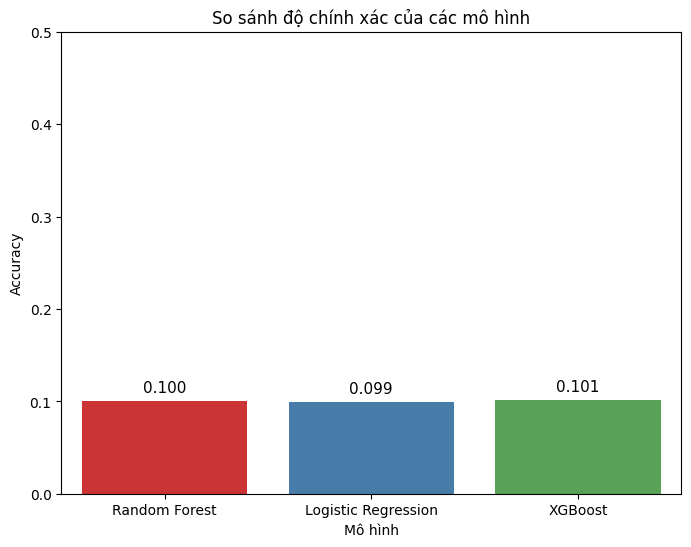

In [55]:
# Lưu Accuracy từng mô hình vào biến
rf_accuracy = acc
lg_accuracy = acc_log_reg
xgb_accuracy = accuracy_score(y_test, xg_pred)

# Tạo DataFrame so sánh
results = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression", "XGBoost"],
    "Accuracy": [rf_accuracy, lg_accuracy, xgb_accuracy]
})

# Vẽ biểu đồ so sánh Accuracy
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Model",
    y="Accuracy",
    data=results,
    palette="Set1"
)

plt.ylim(0, 0.5)
plt.title("So sánh độ chính xác của các mô hình")
plt.ylabel("Accuracy")
plt.xlabel("Mô hình")

# Hiển thị giá trị trên từng cột
for i, acc in enumerate(results["Accuracy"]):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center', fontsize=11)

plt.show()

# **Kết quả và Xuất bản model**

- Kết luận : Dựa trên các chỉ số đánh giá như Accuracy, mô hình XGBoost cho kết quả tối ưu nhất so với Logistic Regression và Random Forest.

# **Xuất bản model được chọn**

In [ ]:
import pickle
fileNameStr= 'xgmodel'
with open(fileNameStr,'wb') as f:
  pickle.dump(xg_model,f)